In [1]:
import sys
from pathlib import Path
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
from src.utils.paths import load_paths
paths = load_paths()


## Importing the 2 JSON files and paths

In [2]:
import pandas as pd
import json
import os
from PIL import Image
import sys
import bioclip
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Load your prepared data
DATA_PATH = paths['processed_dir'] / 'final_data_no_ixodes.json'
CLASS_NAMES_PATH = paths['processed_dir'] / 'class_names_no_ixodes.json'

with open(DATA_PATH, 'r') as f:
    image_data = json.load(f)

with open(CLASS_NAMES_PATH, 'r') as f:
    class_names = json.load(f)

print(f"First few entries in the data:", image_data[:5])
print(f"Printing the class names:", class_names[:7])

print(f"Loaded {len(image_data)} image records.")
print(f"Loaded {len(class_names)} unique class names.")


First few entries in the data: [{'image_path': "/Users/jayjivandas/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Research-Onedrive/Imageomics/Bryant, Cece's files - Tick Images - Copy/ZOE-0013-02-1.jpg", 'true_label': 'Amblyomma americanum', 'sample_id': 'ZOE-0013-02', 'view': 'dorsal', 'sex': 'Male', 'life_stage': 'Adult', 'attached': 'No'}, {'image_path': "/Users/jayjivandas/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Research-Onedrive/Imageomics/Bryant, Cece's files - Tick Images - Copy/ZOE-0013-02-2.jpg", 'true_label': 'Amblyomma americanum', 'sample_id': 'ZOE-0013-02', 'view': 'ventral', 'sex': 'Male', 'life_stage': 'Adult', 'attached': 'No'}, {'image_path': "/Users/jayjivandas/Library/CloudStorage/OneDrive-TheOhioStateUniversity/Research-Onedrive/Imageomics/Bryant, Cece's files - Tick Images - Copy/ZOE-0013-04-1.jpg", 'true_label': 'Ixodes scapularis', 'sample_id': 'ZOE-0013-04', 'view': 'dorsal', 'sex': 'Female', 'life_stage': 'Adult', 'attached': 'No'}, {'image_

## Setting up BioClip with the data

In [3]:
# Import the specific pybioclip classifier
from bioclip import CustomLabelsClassifier

# Initialize the classifier with your list of class names
# The library handles all the model loading and setup internally.
classifier = CustomLabelsClassifier(
    cls_ary=class_names)

print("BioCLIP classifier initialized successfully.")

BioCLIP classifier initialized successfully.


## Testing bioclip on the first image 

In [4]:
# Test BioClip on the first image in your tick dataset
first_item = image_data[0]
image_path = first_item["image_path"]
true_label = first_item["true_label"]

# Run prediction
predictions = classifier.predict(image_path)
for pred in predictions:
    print(f"{pred['classification']:30s}  |  Score: {round(pred['score'], 4)}")

# Show top prediction
top_prediction = predictions[0]["classification"]
score = predictions[0]["score"]

print("\nPredicted:", top_prediction)
print("Confidence:", round(score, 4))
print("True label:", true_label)
print("✅ Correct!" if top_prediction == true_label else "❌ Incorrect.")

100%|██████████| 1/1 [00:05<00:00,  5.09s/images]

Amblyomma maculatum             |  Score: 0.7207
Amblyomma americanum            |  Score: 0.0939
Haemaphysalis longicornis       |  Score: 0.0727
Ixodes dentatus                 |  Score: 0.0437
Dermacentor variabilis          |  Score: 0.0337
Dermacentor andersoni           |  Score: 0.0336
Ixodes cookei                   |  Score: 0.001
Ixodes scapularis               |  Score: 0.0007

Predicted: Amblyomma maculatum
Confidence: 0.7207
True label: Amblyomma americanum
❌ Incorrect.


In [5]:
# Test BioClip on the first image in your tick dataset
first_item = image_data[0]
image_path = first_item["image_path"]
true_label = first_item["true_label"]

# Run prediction
predictions = classifier.predict(image_path)
for pred in predictions:
    print(f"{pred['classification']:30s}  |  Score: {round(pred['score'], 4)}")

# Show top prediction
top_prediction = predictions[0]["classification"]
score = predictions[0]["score"]

print("\nPredicted:", top_prediction)
print("Confidence:", round(score, 4))
print("True label:", true_label)
print("✅ Correct!" if top_prediction == true_label else "❌ Incorrect.")

100%|██████████| 1/1 [00:02<00:00,  2.25s/images]

Amblyomma maculatum             |  Score: 0.7207
Amblyomma americanum            |  Score: 0.0939
Haemaphysalis longicornis       |  Score: 0.0727
Ixodes dentatus                 |  Score: 0.0437
Dermacentor variabilis          |  Score: 0.0337
Dermacentor andersoni           |  Score: 0.0336
Ixodes cookei                   |  Score: 0.001
Ixodes scapularis               |  Score: 0.0007

Predicted: Amblyomma maculatum
Confidence: 0.7207
True label: Amblyomma americanum
❌ Incorrect.


## Running all the images on BioClip, getting the dorsal, ventral and total accuracies.

In [6]:
from collections import defaultdict

# Group entries by sample_id
samples = defaultdict(dict)
for entry in image_data:
    samples[entry['sample_id']][entry['view']] = entry

dorsal_correct = 0
ventral_correct = 0
highest_conf_correct = 0
total = 0

# Per-class stats
dorsal_class_correct = defaultdict(int)
dorsal_class_total = defaultdict(int)
ventral_class_correct = defaultdict(int)
ventral_class_total = defaultdict(int)
highest_conf_class_correct = defaultdict(int)
highest_conf_class_total = defaultdict(int)

# Storing predictions and ground truths for a confusion matrix
y_true = []
y_pred = []

for sample_id, views in samples.items():
    dorsal = views.get('dorsal')
    ventral = views.get('ventral')
    if not dorsal or not ventral:
        continue  # skip incomplete pairs

    # Predict dorsal
    dorsal_preds = classifier.predict(dorsal['image_path'])
    dorsal_top = dorsal_preds[0]['classification']
    dorsal_score = dorsal_preds[0]['score']
    dorsal_true = dorsal['true_label']

    # Predict ventral
    ventral_preds = classifier.predict(ventral['image_path'])
    ventral_top = ventral_preds[0]['classification']
    ventral_score = ventral_preds[0]['score']
    ventral_true = ventral['true_label']

    # Dorsal accuracy
    dorsal_class_total[dorsal_true] += 1
    if dorsal_top == dorsal_true:
        dorsal_correct += 1
        dorsal_class_correct[dorsal_true] += 1

    # Ventral accuracy
    ventral_class_total[ventral_true] += 1
    if ventral_top == ventral_true:
        ventral_correct += 1
        ventral_class_correct[ventral_true] += 1

    # Highest confidence
    if dorsal_score >= ventral_score:
        best_pred = dorsal_top
        best_true = dorsal_true
    else:
        best_pred = ventral_top
        best_true = ventral_true
    highest_conf_class_total[best_true] += 1
    if best_pred == best_true:
        highest_conf_correct += 1
        highest_conf_class_correct[best_true] += 1
    
    # Store predictions and ground truths for confusion matrix
    y_true.append(best_true)
    y_pred.append(best_pred)

    total += 1

print(f"Dorsal accuracy: {dorsal_correct/total:.3f}")
print(f"Ventral accuracy: {ventral_correct/total:.3f}")
print(f"Highest confidence accuracy: {highest_conf_correct/total:.3f}")
print(f"Total evaluated samples: {total}")

# Per-class accuracy
dorsum = 0
print("\nPer-class dorsal accuracy:")
for cls in sorted(dorsal_class_total):
    acc = dorsal_class_correct[cls] / dorsal_class_total[cls]
    dorsum += acc
    print(f"{cls:30s} | {acc:.3f}")

# calculating dorsal macro accuracy
dorsal_macro_acc = dorsum / len(dorsal_class_total)
print(f"\nDorsal Macro-Accuracy: {dorsal_macro_acc:.3f}")

vensum = 0
print("\nPer-class ventral accuracy:")
for cls in sorted(ventral_class_total):
    acc = ventral_class_correct[cls] / ventral_class_total[cls]
    vensum += acc
    print(f"{cls:30s} | {acc:.3f}")

# calculating ventral macro accuracy
ven_macro_acc = vensum / len(ventral_class_total)
print(f"\nVentral Macro-Accuracy: {ven_macro_acc:.3f}")

hcasum = 0
print("\nPer-class highest confidence accuracy:")
for cls in sorted(highest_conf_class_total):
    acc = highest_conf_class_correct[cls] / highest_conf_class_total[cls]
    hcasum += acc
    print(f"{cls:30s} | {acc:.3f}")

# calculating highest confidence macro accuracy
hca_macro_acc = hcasum / len(highest_conf_class_total)
print(f"\nHighest Confidence Macro-Accuracy: {hca_macro_acc:.3f}")

100%|██████████| 1/1 [00:02<00:00,  2.03s/images]

Dorsal accuracy: 0.682
Ventral accuracy: 0.532
Highest confidence accuracy: 0.643
Total evaluated samples: 616

Per-class dorsal accuracy:
Amblyomma americanum           | 0.122
Amblyomma maculatum            | 1.000
Dermacentor andersoni          | 1.000
Dermacentor variabilis         | 0.821
Haemaphysalis longicornis      | 0.829
Ixodes cookei                  | 0.000
Ixodes dentatus                | 0.778
Ixodes scapularis              | 0.813

Dorsal Macro-Accuracy: 0.670

Per-class ventral accuracy:
Amblyomma americanum           | 0.033
Amblyomma maculatum            | 0.833
Dermacentor andersoni          | 1.000
Dermacentor variabilis         | 0.643
Haemaphysalis longicornis      | 0.800
Ixodes cookei                  | 0.000
Ixodes dentatus                | 0.778
Ixodes scapularis              | 0.619

Ventral Macro-Accuracy: 0.588

Per-class highest confidence accuracy:
Amblyomma americanum           | 0.089
Amblyomma maculatum            | 1.000
Dermacentor andersoni        

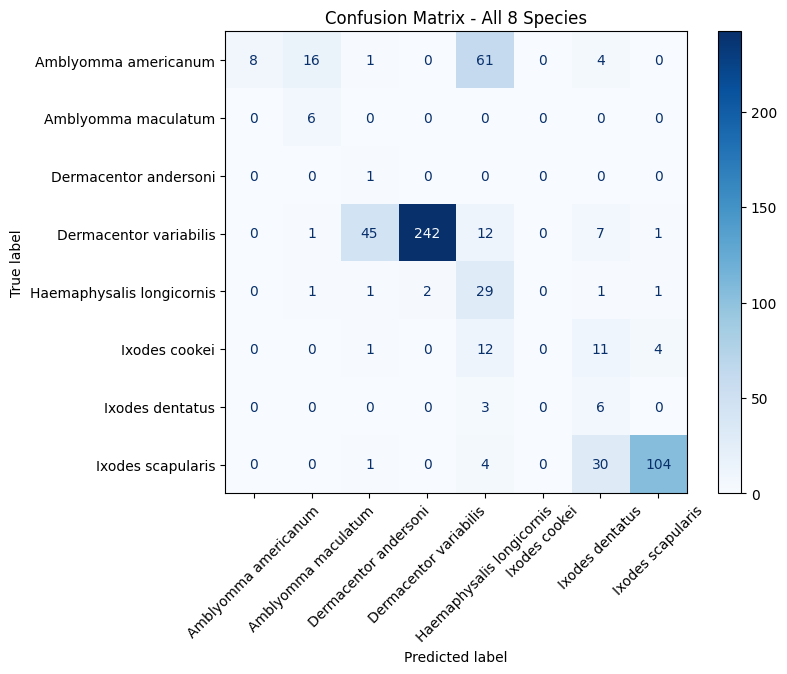

Confusion Matrix (raw counts):
[[  8  16   1   0  61   0   4   0]
 [  0   6   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0]
 [  0   1  45 242  12   0   7   1]
 [  0   1   1   2  29   0   1   1]
 [  0   0   1   0  12   0  11   4]
 [  0   0   0   0   3   0   6   0]
 [  0   0   1   0   4   0  30 104]]


In [7]:
# Use the class_names list from your notebook
species_labels = class_names  # already cleaned and matches your dataset order

# Generate confusion matrix
cm_full = confusion_matrix(y_true, y_pred, labels=species_labels)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm_full, display_labels=species_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix - All 8 Species")
plt.show()

# (Optional) Print raw matrix for debugging
print("Confusion Matrix (raw counts):")
print(cm_full)


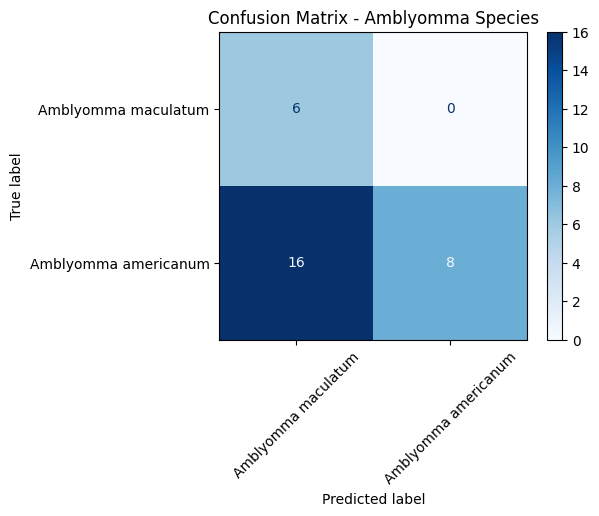

Amblyomma Confusion Matrix (raw counts):
[[ 6  0]
 [16  8]]


In [8]:
# Creating Separate 2x2 Matrices for Amblyomma maculatum vs Amblyomma americanum
# Define the labels for Amblyomma species
amb_labels = ["Amblyomma maculatum", "Amblyomma americanum"]

# Filter y_true and y_pred to only include Amblyomma samples
amb_true = [true for true, pred in zip(y_true, y_pred) if true in amb_labels]
amb_pred = [pred for true, pred in zip(y_true, y_pred) if true in amb_labels]

# Generate confusion matrix for Amblyomma species
cm_amb = confusion_matrix(amb_true, amb_pred, labels=amb_labels)

# Plot
disp_amb = ConfusionMatrixDisplay(confusion_matrix=cm_amb, display_labels=amb_labels)
fig, ax = plt.subplots(figsize=(5, 4))
disp_amb.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix - Amblyomma Species")
plt.show()

print("Amblyomma Confusion Matrix (raw counts):")
print(cm_amb)



In [9]:
# # Define the labels for Ixodes species
# ix_labels = ["Ixodes", "Ixodes scapularis"]

# # Filter y_true and y_pred to only include Ixodes samples
# ix_true = [true for true, pred in zip(y_true, y_pred) if true in ix_labels]
# ix_pred = [pred for true, pred in zip(y_true, y_pred) if true in ix_labels]

# # Generate confusion matrix for Ixodes species
# cm_ix = confusion_matrix(ix_true, ix_pred, labels=ix_labels)

# # Plot
# disp_ix = ConfusionMatrixDisplay(confusion_matrix=cm_ix, display_labels=ix_labels)
# fig, ax = plt.subplots(figsize=(5, 4))
# disp_ix.plot(cmap='Blues', xticks_rotation=45, ax=ax)
# plt.title("Confusion Matrix - Ixodes Species")
# plt.show()

# print("Ixodes Confusion Matrix (raw counts):")
# print(cm_ix)
